In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import EPPE_Simulator as eppe
import astropy.constants as const

import scipy.optimize as spopt

# from EPPE_Simulator import cross_match
# cross_match.cross_match_tables()

In [2]:
expTime = 1 # Exposure time

randomOrientation = False # Randomly orient planets (useful for single planet simulations, but not full catalogue)
albedo = 0.1#'theo' # use an float to set all albedos the same, or 'theo' for predictions from Sudarsky+2000
polEff = 0.6 # planetary polarization efficiency (0.6 for disk integrated Rayleigh-Lambertian scattering)
filt = 'EPPE' # Filter or effective filter
trans = 0.85 # Throughput of optical system (excluding an explicit filters)

phoenixFolder = '/home/taylor/Documents/Research/PHOENIX/MedResFITS/R10000FITS/' # location where you want to save PHOENIX stellar models (default is './PHONEIX/MedResFITS/R10000FITS/')

savePlots = False
savepath = 'saves/'

In [3]:
systems = eppe.Systems(load=True, polEff=polEff, randomOrientation=randomOrientation, albedo=albedo, phoenixFolder=phoenixFolder) #load in the systems

systems.catalogue['albedo'][systems.catalogue['rp']/const.R_earth.value<6.] = 0.3 # set albedos for smaller planets higher, since we can accept a worse constraint on their albedo

mission = eppe.mission(systems, filt=filt, trans=trans, usePhoenix=True) # EPPE

In [4]:
print(mission.pemCent)

5.61422375565563e-07


In [5]:
teq = systems.catalogue['teq']
rps = systems.catalogue['rp']

# Run the simulations
amps = mission.compute_amps()
noise = mission.compute_noise(expTime)
SNRs = mission.compute_SNR(amps=amps, noise=noise)
_, fstar, _ = mission.expose_photometric(expTime, rnd=False)

### Figuring out photon noise levels

In [6]:
def func(amp,x):
    return amp*10**(x/5)

def min_func(amp, x, y):
    return np.median((y-func(amp, x))**2)*1e7

 final_simplex: (array([[5.000e-07],
       [5.125e-07]]), array([0.00403922, 0.00409874]))
           fun: 0.004039216181649826
       message: 'Optimization terminated successfully.'
          nfev: 16
           nit: 8
        status: 0
       success: True
             x: array([5.e-07])


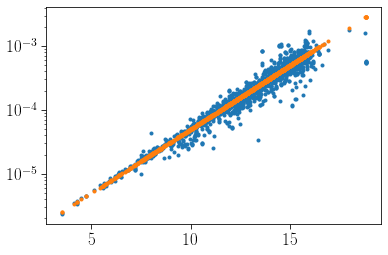

In [7]:
spy_result = spopt.minimize(min_func, [1e-6], (systems.catalogue['optMag'], noise), 'Nelder-Mead')

print(spy_result)

plt.semilogy(systems.catalogue['optMag'], noise, '.')
plt.plot(systems.catalogue['optMag'], func(spy_result.x,systems.catalogue['optMag']), '.')
plt.show()

# Make plots for the simulated observations

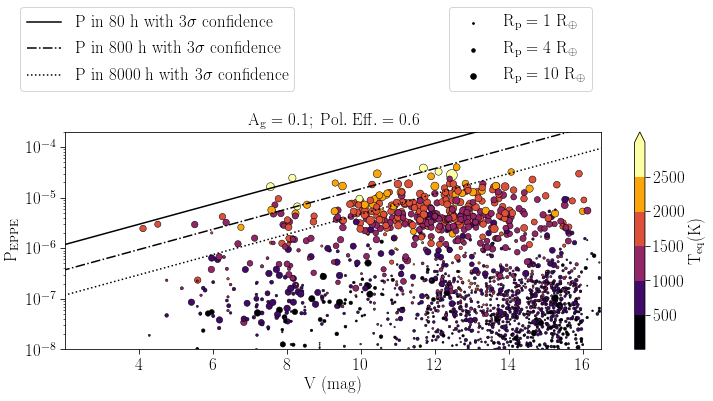

In [8]:
fig = plt.figure(figsize=(12,4))

cmap = plt.get_cmap('inferno', 6)

good = teq > -1

# additive offset found using median approxMag-optMag
approxMag = -2.5*np.log10(fstar) + 27.290663305524518
optMag = systems.catalogue['optMag']

plt.scatter(x=optMag[good], y=amps[good], c=teq[good], s=3*rps[good]/const.R_earth.value, cmap=cmap, vmin=0, vmax=3000, edgecolor='k', linewidth=0.5)
cbar = plt.colorbar(label=r'$\rm T_{eq} (K)$', extend='max')
cbar.set_ticks([500,1000,1500,2000,2500])

x = np.linspace(0,20,1000)

tint = 80
limit = 3/np.sqrt(tint/expTime)*np.sqrt(2)*func(spy_result.x,x)
limit += mission.pNoiseFloor
limit *= 2 # multiplier for only measuring one polarization state at a time
plt.plot(x, limit, c='k', ls='-', label=r'$\rm P~in~'+str(tint)+'~h~with~3\sigma~confidence$')

tint = 800
limit = 3/np.sqrt(tint/expTime)*np.sqrt(2)*func(spy_result.x,x)
limit += mission.pNoiseFloor
limit *= 2 # multiplier for only measuring one polarization state at a time
plt.plot(x, limit, c='k', ls='-.', label=r'$\rm P~in~'+str(tint)+'~h~with~3\sigma~confidence$')

tint = 8000
limit = 3/np.sqrt(tint/expTime)*np.sqrt(2)*func(spy_result.x,x)
limit += mission.pNoiseFloor
limit *= 2 # multiplier for only measuring one polarization state at a time
plt.plot(x, limit, c='k', ls='dotted', label=r'$\rm P~in~'+str(tint)+'~h~with~3\sigma~confidence$')


plt.yscale('log')
plt.ylim(1e-8,2e-4)
plt.xlim(2,16.5)
plt.xticks([4,6,8,10,12,14,16])

plt.xlabel(r'$\rm V~(mag)$')
plt.ylabel(r'$\rm P_{'+filt+'}$')
if albedo != 'theo':
    plt.title(r'$\rm A_g = '+str(albedo)+';~Pol.~Eff. = '+str(polEff)+'$')
else:
    plt.title(r'$\rm Predicted~A_g;~Pol.~Eff. = '+str(polEff)+'$')

rp = 1
d1 = plt.scatter(x=1000, y=1e-12, c='k', s=3*rp, label=r'$\rm R_p = '+str(rp)+'~R_{\oplus}$')
rp = 4
d2 = plt.scatter(x=1000, y=1e-12, c='k', s=3*rp, label=r'$\rm R_p = '+str(rp)+'~R_{\oplus}$')
rp = 10
d3 = plt.scatter(x=1000, y=1e-12, c='k', s=3*rp, label=r'$\rm R_p = '+str(rp)+'~R_{\oplus}$')

handles, labels = plt.gca().get_legend_handles_labels()
legend1 = plt.legend(handles[:3], labels[:3], loc=3, bbox_to_anchor=(-0.1,1.15))
legend2 = plt.legend(handles[3:], labels[3:], loc=3, bbox_to_anchor=(0.7,1.15))
plt.gca().add_artist(legend1)

if savePlots:
    if albedo=='theo':
        plt.savefig(savepath+'PV_vs_V_theoAg.png', dpi=300, bbox_inches='tight')
    else:
        plt.savefig(savepath+'PV_vs_V.png', dpi=300, bbox_inches='tight')
plt.show()

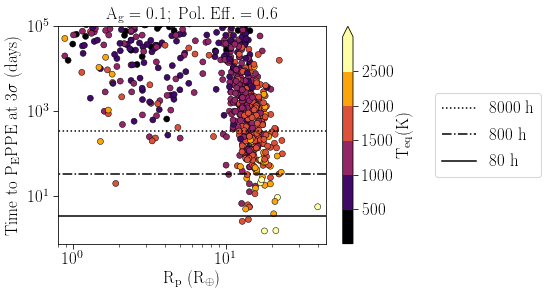

In [9]:
tint = 1
limit = 1/np.sqrt(tint/expTime)*3*np.sqrt(2)*noise[np.argmin(approxMag)]*(10**((approxMag-np.min(approxMag))/5))

x = rps[good]/const.R_earth.value
tToThreeSig = (limit/amps)[good]**2/24.

tToThreeSig *= 2 # multiplier for only measuring one polarization state at a time

cmap = plt.get_cmap('inferno', 6)
plt.scatter(x, tToThreeSig, c=teq[good], cmap=cmap, vmin=0, vmax=3000, edgecolor='k', linewidth=0.5)
cbar = plt.colorbar(label=r'$\rm T_{eq} (K)$', extend='max')
cbar.set_ticks([500,1000,1500,2000,2500])

plt.plot([0,1e5], [8000/24.,8000/24.], c='k', ls='dotted', label=r'$\rm 8000~h$')
plt.plot([0,1e5], [800/24.,800/24.], c='k', ls='-.', label=r'$\rm 800~h$')
plt.plot([0,1e5], [80/24.,80/24.], c='k', ls='-', label=r'$\rm 80~h$')

plt.yscale('log')
plt.xscale('log')
plt.ylim(np.min([np.nanmin(tToThreeSig[tToThreeSig>0])/2., 50/24.]),1e5)
plt.xlim(8e-1,45)

if albedo != 'theo':
    plt.title(r'$\rm A_g = '+str(albedo)+';~Pol.~Eff. = '+str(polEff)+'$')
else:
    plt.title(r'$\rm Predicted~A_g;~Pol.~Eff. = '+str(polEff)+'$')
plt.ylabel(r'$\rm Time~to~P_'+filt+'~at~3\sigma~(days)$')
plt.xlabel(r'$\rm R_p~(R_{\oplus})$')

plt.legend(loc=6, bbox_to_anchor=(1.375,0.5))

if savePlots:
    if albedo=='theo':
        plt.savefig(savepath+'Stare_vs_Rp_theoAg.png', dpi=300, bbox_inches='tight')
    else:
        plt.savefig(savepath+'Stare_vs_Rp.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
nPlanets = 10
nEarths = 10
fullNames = np.array([])
fullInds = np.array([], dtype=int)

output = ''

if albedo == 'theo':
    output += 'Assuming predicted Ag, Pol. Eff. = '+str(polEff)+'\n\n\n'
else:
    output += 'Fixed depth in Ag, Pol. Eff. = '+str(polEff)+'\n\n\n'

for teqMin in range(1000,3000,500):
    if teqMin<2500:
        teqMax = teqMin+500
    else:
        teqMax = np.inf
    inds = np.where(np.logical_and(np.logical_and(np.logical_and(teqMin <= teq, teq < teqMax), tToThreeSig<40), rps/const.R_earth.value>6))[0]
    inds = inds[np.argsort(tToThreeSig[inds])]
    if len(inds) > nPlanets:
        inds = inds[:nPlanets]
    names = systems.catalogue['name'][inds]
    ras = (24./360.*systems.catalogue['ra'][inds]).astype(str)
    decs = systems.catalogue['dec'][inds].astype(str)
    fullNames = np.append(fullNames, names)
    fullInds = np.append(fullInds, inds)
    output += str(teqMin)+' K < Teq <= '+str(teqMax)+' K\n'
    output += 'names = [\''+'\', \''.join(names)+'\']\n'
    output += 'RA = ['+', '.join(ras)+']\n'
    output += 'DEC = ['+', '.join(decs)+']\n'
    output += 'Teqs = ['+', '.join(np.rint(teq[inds]).astype(int).astype(str))+'] (K)\n'
    output += 'Rps = ['+', '.join(np.round(rps[inds]/const.R_jup.value,1).astype(str))+'] (R_jup)\n'
    output += 'Albedo = ['+', '.join((np.round(systems.catalogue['albedo'][inds], 2)).astype(str))+']\n'
    output += 'Pol. Amp. = ['+', '.join((np.round(amps[inds]*1e6, 2)).astype(str))+'] ppm\n'
    output += 'Time to 3 sig = ['+', '.join(np.round(tToThreeSig[inds],2).astype(str))+'] (days)\n\n'

output += '\nMax time to 3 sigma:    '+str(np.round(np.max(tToThreeSig[fullInds]), 2))+' days\n'
output += 'Mean time to 3 sigma:   '+str(np.round(np.mean(tToThreeSig[fullInds]), 2))+' days\n'
output += 'Median time to 3 sigma: '+str(np.round(np.median(tToThreeSig[fullInds]), 2))+' days\n'
output += 'Min time to 3 sigma:    '+str(np.round(np.min(tToThreeSig[fullInds]), 2))+' days\n\n\n'
output += ('Total time to 3 sigma:  '+str(np.round(np.sum(tToThreeSig[fullInds]), 2))+' days'+
                                     ' ('+str(np.round(np.sum(tToThreeSig[fullInds])/365., 2))+' years)\n\n\n')
    
inds = np.where(np.logical_and(rps/const.R_earth.value < 6, tToThreeSig<100))[0]
inds = inds[np.argsort(tToThreeSig[inds])]
if len(inds) > nEarths:
    inds = inds[:nEarths]
if len(inds) != 0:
    names = systems.catalogue['name'][inds]
    ras = (24./360.*systems.catalogue['ra'][inds]).astype(str)
    decs = systems.catalogue['dec'][inds].astype(str)
    fullNames = np.append(fullNames, names)
    fullInds = np.append(fullInds, inds)
    output += 'Rp < 6 R_earth\n'
    output += 'names = [\''+'\', \''.join(names)+'\']\n'
    output += 'RA = ['+', '.join(ras)+']\n'
    output += 'DEC = ['+', '.join(decs)+']\n'
    output += 'Teqs = ['+', '.join(np.rint(teq[inds]).astype(int).astype(str))+'] (K)\n'
    output += 'Rps = ['+', '.join(np.round(rps[inds]/const.R_jup.value,1).astype(str))+'] (R_jup)\n'
    output += 'Albedo = ['+', '.join((np.round(systems.catalogue['albedo'][inds], 2)).astype(str))+']\n'
    output += 'Pol. Amp. = ['+', '.join((np.round(amps[inds]*1e6, 2)).astype(str))+'] ppm\n'
    output += 'Time to 3 sig = ['+', '.join(np.round(tToThreeSig[inds],2).astype(str))+'] (days)\n\n'

    output += '\nMax time to 3 sigma:    '+str(np.round(np.max(tToThreeSig[inds]), 2))+' days\n'
    output += 'Mean time to 3 sigma:   '+str(np.round(np.mean(tToThreeSig[inds]), 2))+' days\n'
    output += 'Median time to 3 sigma: '+str(np.round(np.median(tToThreeSig[inds]), 2))+' days\n'
    output += 'Min time to 3 sigma:    '+str(np.round(np.min(tToThreeSig[inds]), 2))+' days\n\n\n'
    output += ('Total time to 3 sigma:  '+str(np.round(np.sum(tToThreeSig[inds]), 2))+' days'+
                                         ' ('+str(np.round(np.sum(tToThreeSig[inds])/365., 2))+' years)\n\n\n')

output += ('Total Number of Targets: '+str(len(fullInds))+'\n')
output += ('Integration time required over mission lifetime:  '+str(np.round(np.sum(tToThreeSig[fullInds])/365., 2))+' years\n\n\n')

fullNames = np.unique(fullNames)
fullInds = np.unique(fullInds)

print(output)

if savePlots:
    with open(savepath+'suggestedTargets.txt', "w") as text_file:
        text_file.write(output)

Fixed depth in Ag, Pol. Eff. = 0.6


1000 K < Teq <= 1500 K
names = ['51 Peg b', 'HD 189733 b', 'HD 75289 b', 'HD 209458 b', 'HD 187123 b', 'WASP-43 b', 'HD 83443 b']
RA = [22.9577718, 20.01214193333334, 8.7945526, 22.052992733333333, 19.7828084, 10.327224800000002, 9.619952400000003]
DEC = [20.768833, 22.710854, -41.736794, 18.884319, 34.419525, -9.806276, -43.272205]
Teqs = [1333, 1192, 1463, 1477, 1467, 1379, 1272] (K)
Rps = [1.3, 1.1, 1.3, 1.4, 1.3, 0.9, 1.1] (R_jup)
Albedo = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Pol. Amp. = [2.94, 7.2, 3.23, 4.82, 4.87, 23.69, 4.35] ppm
Time to 3 sig = [5.54, 6.59, 12.45, 16.97, 19.15, 31.94, 38.42] (days)

1500 K < Teq <= 2000 K
names = ['tau Boo b', 'ups And b', 'HD 212301 b', 'HD 179949 b', 'WASP-77 A b', 'KELT-14 b', 'HD 88133 b', 'HAT-P-32 b']
RA = [13.787706533333333, 1.6132896666666667, 22.45858966666667, 19.259230533333334, 2.4770076666666667, 7.220099, 10.1687988, 2.0695232]
DEC = [17.456905, 41.40546, -77.717926, -24.179352, -7.060681, -42

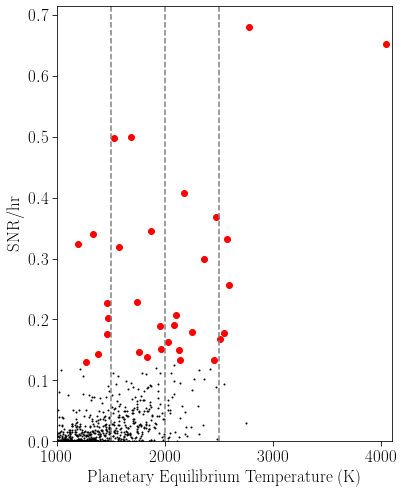

In [11]:
fig = plt.figure(figsize=(6.,8))

plt.plot(teq, SNRs, '.', c='k', ms=2)
plt.plot(teq[fullInds], SNRs[fullInds], 'o', c='r')

plt.gca().axvline(1500, c='gray', ls='--')
plt.gca().axvline(2000, c='gray', ls='--')
plt.gca().axvline(2500, c='gray', ls='--')

plt.xlim(1000,4100)
plt.ylim(0)

plt.ylabel(r'$\rm SNR/hr$')
plt.xlabel(r'$\rm Planetary~Equilibrium~Temperature~(K)$')

plt.savefig('/home/taylor/Downloads/SNR_vs_Teq.png', dpi=300, bbox_inches='tight')
plt.show()

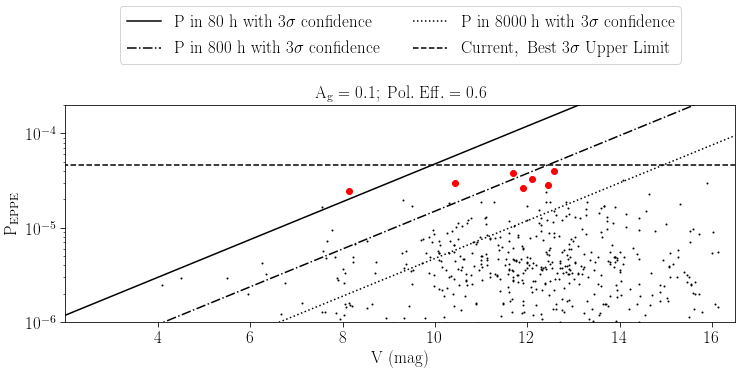

In [12]:
fig = plt.figure(figsize=(12,4))

cmap = plt.get_cmap('inferno', 6)

# good = rps/const.R_earth.value >= 6.
# good = teq < 2000
good = teq > -1

# additive offset found using median approxMag-optMag
approxMag = -2.5*np.log10(fstar) + 27.290663305524518
optMag = systems.catalogue['optMag']

plt.plot(optMag[good], amps[good], '.', c='k', ms=2)
plt.plot(optMag[fullInds][np.argsort(amps[fullInds])[::-1][:7]], amps[fullInds][np.argsort(amps[fullInds])[::-1][:7]], 'o', c='r')

x = np.linspace(0,20,1000)

tint = 80
# limit = 1/np.sqrt(tint/expTime)*3*np.sqrt(2)*noise[np.argmin(approxMag)]*(10**((x-np.min(approxMag))/5))
limit = 3/np.sqrt(tint/expTime)*np.sqrt(2)*func(spy_result.x,x)
limit += mission.pNoiseFloor
limit *= 2 # multiplier for only measuring one polarization state at a time
# limit *= 2 # multiplier for only 50% visibility from low-Earth, Sun-synchronous orbit
plt.plot(x, limit, c='k', ls='-', label=r'$\rm P~in~'+str(tint)+'~h~with~3\sigma~confidence$')

tint = 800
# limit = 1/np.sqrt(tint/expTime)*3*np.sqrt(2)*noise[np.argmin(approxMag)]*(10**((x-np.min(approxMag))/5))
limit = 3/np.sqrt(tint/expTime)*np.sqrt(2)*func(spy_result.x,x)
limit += mission.pNoiseFloor
limit *= 2 # multiplier for only measuring one polarization state at a time
# limit *= 2 # multiplier for only 50% visibility from low-Earth, Sun-synchronous orbit
plt.plot(x, limit, c='k', ls='-.', label=r'$\rm P~in~'+str(tint)+'~h~with~3\sigma~confidence$')

tint = 8000
# limit = 1/np.sqrt(tint/expTime)*3*np.sqrt(2)*noise[np.argmin(approxMag)]*(10**((x-np.min(approxMag))/5))
limit = 3/np.sqrt(tint/expTime)*np.sqrt(2)*func(spy_result.x,x)
limit += mission.pNoiseFloor
limit *= 2 # multiplier for only measuring one polarization state at a time
# limit *= 2 # multiplier for only 50% visibility from low-Earth, Sun-synchronous orbit
plt.plot(x, limit, c='k', ls='dotted', label=r'$\rm P~in~'+str(tint)+'~h~with~3\sigma~confidence$')

plt.plot(x, 15.6*3*1e-6*np.ones_like(x), c='k', ls='--', label=r'$\rm Current,~Best~3\sigma~Upper~Limit$')

plt.yscale('log')
plt.ylim(1e-6,2e-4)
plt.xlim(2,16.5)
plt.xticks([4,6,8,10,12,14,16])

plt.xlabel(r'$\rm V~(mag)$')
plt.ylabel(r'$\rm P_{'+filt+'}$')
if albedo != 'theo':
    plt.title(r'$\rm A_g = '+str(albedo)+';~Pol.~Eff. = '+str(polEff)+'$')
else:
    plt.title(r'$\rm Predicted~A_g;~Pol.~Eff. = '+str(polEff)+'$')

# handles, labels = plt.gca().get_legend_handles_labels()
legend1 = plt.legend(loc=8, bbox_to_anchor=(0.5,1.15), ncol=2)
# plt.gca().add_artist(legend1)

plt.savefig('/home/taylor/Downloads/Threshold_Mission.png', dpi=300, bbox_inches='tight')
plt.show()

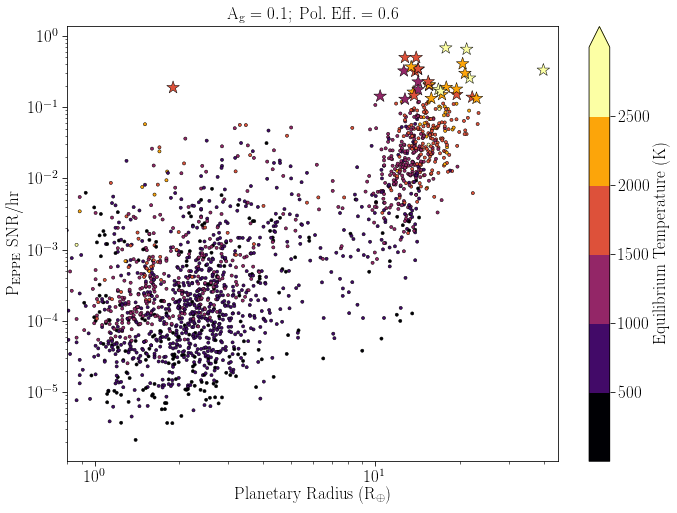

In [13]:
fig = plt.figure(figsize=(11,8))
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(np.nanmin(SNRs[SNRs>0])/2, np.nanmax(SNRs[np.isfinite(SNRs)])*2)
ax.set_xlim(8e-1,45)
ax.set_ylabel(r'$\rm P_{'+filt+'}~SNR/hr$')
ax.set_xlabel(r'$\rm Planetary~Radius~(R_{\oplus})$')

cmap = plt.get_cmap('inferno', 6)

scat = ax.scatter(x=rps/const.R_earth.value, y=SNRs, c=teq, marker='o', s=10, cmap=cmap, vmin=0, vmax=3000, edgecolor='k', linewidth=0.5)
scat = ax.scatter(x=rps[fullInds]/const.R_earth.value, y=SNRs[fullInds], c=teq[fullInds], marker='*', s=175, cmap=cmap, vmin=0, vmax=3000, edgecolor='k', linewidth=0.5)
cbar = fig.colorbar(scat, ax=ax, label=r'$\rm Equilibrium~Temperature~(K)$', extend='max')
cbar.set_ticks([500,1000,1500,2000,2500])

if albedo != 'theo':
    plt.title(r'$\rm A_g = '+str(albedo)+';~Pol.~Eff. = '+str(polEff)+'$')
else:
    plt.title(r'$\rm Predicted~A_g;~Pol.~Eff. = '+str(polEff)+'$')

if savePlots:
    plt.savefig(savepath+'suggestedTargets.pdf', bbox_inches='tight')

plt.show()
plt.close(fig)

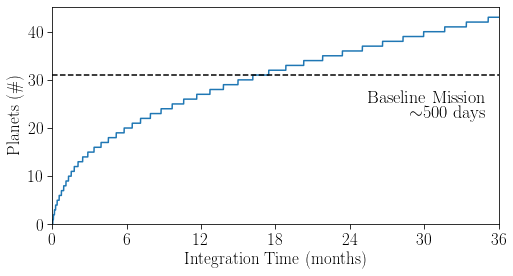

In [14]:
intTimes = np.sort(tToThreeSig)
xs = np.linspace(0,3,100000,endpoint=True)

ys = [0]
timeUsed = 0
for x in xs[1:]:
    if intTimes[0] <= x*365-timeUsed:
        timeUsed += intTimes[0]
        intTimes = intTimes[1:]
        ys.append(ys[-1]+1)
    else:
        ys.append(ys[-1])
ys = np.array(ys)




fig = plt.figure(figsize=[8,4])

plt.plot(xs*365/30,ys)
plt.ylim(0)
plt.xlim(0,36)
plt.xticks([0,6,12,18,24,30,36])

baselinePlanets = fullInds.size-1
# plt.plot([0,36],[10,10], c='k', label=r'$\rm Threshold~Mission$')
plt.plot([0,36],[baselinePlanets,baselinePlanets], c='k', ls='--', label=r'$\rm Baseline~Mission$')

# plt.text(35, 7, r'$\rm Threshold~Mission$', fontsize=18, ha='right')
# plt.text(35, 4, r'$\rm {\sim}'+str(int(np.rint(xs[ys>=10][0]*365/10)*10))+r'~days$', fontsize=18, ha='right')

plt.text(35, 25, r'$\rm Baseline~Mission$', fontsize=18, ha='right')
plt.text(35, 22, r'$\rm {\sim}'+str(int(np.rint(np.sum(tToThreeSig[fullInds[systems.catalogue['name'][fullInds]!='55 Cnc e']])/10)*10))+r'~days$', fontsize=18, ha='right')


plt.ylabel(r'$\rm Planets~(\#)$')
plt.xlabel(r'$\rm Integration~Time~(months)$')

# plt.legend(loc='best')

if savePlots:
    fname = savepath+'discovery_rate'
    if albedo=='theo':
        fname += '_theoAg'
    plt.savefig(fname+'.png', dpi=400, bbox_inches='tight')
plt.show()

# Some simple plots to see how widely distributed our targets are

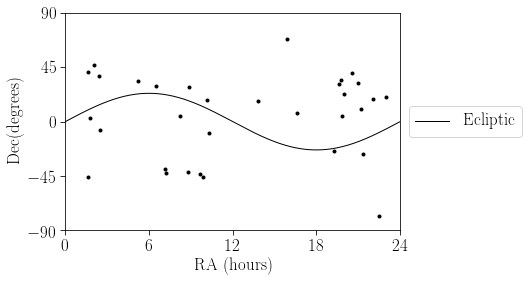

In [15]:
plt.plot(systems.catalogue['ra'][fullInds]*24./360., systems.catalogue['dec'][fullInds], '.', c='k')
x = np.linspace(0,24,1000)
y = 23.43681*np.sin(x*np.pi/12.)
plt.plot(x, y, c='k', lw=1, label=r'$\rm Ecliptic$')
plt.xlabel(r'$\rm RA~(hours)$')
plt.ylabel(r'$\rm Dec (degrees)$')
plt.xticks(np.linspace(0,24,5))
plt.yticks(np.linspace(-90,90,5))
plt.xlim(0,24)
plt.ylim(-90,90)
plt.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.show()

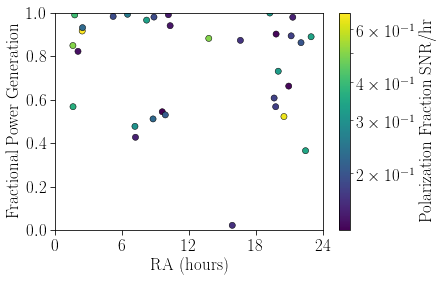

Mean Power Generation: 76% full capacity
Median Power Generation: 87% full capacity


In [16]:
x = systems.catalogue['ra'][fullInds]*24./360.
yEcliptic = 23.43681*np.sin(x*np.pi/12.)
# y = (systems.catalogue['dec'][fullInds] - yEcliptic)
power = np.cos((systems.catalogue['dec'][fullInds] - yEcliptic)*np.pi/180.)

fig = plt.gcf()
ax = plt.gca()

scat = ax.scatter(x=x, y=power, c=SNRs[fullInds], marker='.', s=150, cmap='viridis', norm=colors.LogNorm(), edgecolors='k', linewidth=0.5)
cbar = fig.colorbar(scat, ax=ax, label=r'$\rm Polarization~Fraction~SNR/hr$')
ax.set_xlabel(r'$\rm RA~(hours)$')
ax.set_ylabel(r'$\rm Fractional~Power~Generation$')
ax.set_xticks(np.linspace(0,24,5))
ax.set_xlim(0,24)
ax.set_ylim(0,1)

if savePlots:
    plt.savefig(savepath+'PowerGeneration_vs_RA.png', dpi=300, bbox_inches='tight')

plt.show()

print('Mean Power Generation: '+str(int(np.rint(np.mean(power)*100)))+'% full capacity')
print('Median Power Generation: '+str(int(np.rint(np.median(power)*100)))+'% full capacity')

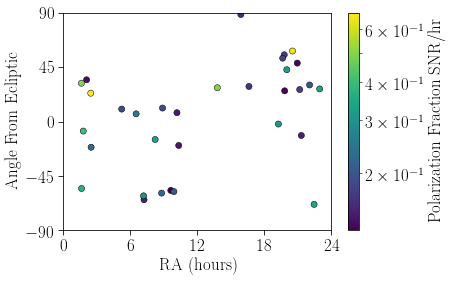

Mean Angle: 35.61 degrees
Median Angle: 29.71 degrees


In [17]:
x = systems.catalogue['ra'][fullInds]*24./360.
yEcliptic = 23.43681*np.sin(x*np.pi/12.)
y = (systems.catalogue['dec'][fullInds] - yEcliptic)

fig = plt.gcf()
ax = plt.gca()

scat = ax.scatter(x=x, y=y, c=SNRs[fullInds], marker='.', s=150, cmap='viridis', norm=colors.LogNorm(), edgecolors='k', linewidth=0.5)
cbar = fig.colorbar(scat, ax=ax, label=r'$\rm Polarization~Fraction~SNR/hr$')
ax.set_xlabel(r'$\rm RA~(hours)$')
ax.set_ylabel(r'$\rm Angle~From~Ecliptic$')
ax.set_xticks(np.linspace(0,24,5))
ax.set_yticks(np.linspace(-90,90,5))
ax.set_xlim(0,24)
ax.set_ylim(-90,90)

# if savePlots:
#     plt.savefig(savepath+'PowerGeneration_vs_RA.png', dpi=300, bbox_inches='tight')

plt.show()

print('Mean Angle: '+str(np.round(np.mean(np.abs(y)), 2))+' degrees')
print('Median Angle: '+str(np.round(np.median(np.abs(y)), 2))+' degrees')

In [18]:
np.percentile(np.abs(y), 15)

10.92977528938574

In [19]:
len(np.where(np.abs(y)<15)[0])/len(y)

0.25

In [20]:
np.percentile(power,25)

0.5627733225448566

In [21]:
len(np.where(power>0.5)[0])/len(power)

0.875

In [22]:
systems.catalogue['name'][fullInds][np.argmin(power)]

'HD 143105 b'